# Monte Carlo Methods

<hr>

In the dynamic programming setting, the agent already had a full knowledge of the environment's dynamics. However in Monte Carlo, the agent doesn't have a full knowledge of how environment operates. Instead it must learn through interaction with environment. 

In this notebook, you will write your own implementations of many Monte Carlo (MC) algorithms. 

# 1. Explore Blackjack Environment

<hr>

You can read about the game of Blackjack in <a href="http://go.udacity.com/rl-textbook">Example 5.1 of the Reinforcement Learning an Introduction</a>. You can also review the corresponding <a href="https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py">GitHub file</a>, by reading the commented block in the BlackjackEnv class.


In [1]:
# Import the libraries
import sys
import gym
import numpy as np
from collections import defaultdict
from plot_utils import plot_blackjack_values, plot_policy

In [2]:
# Create an instance of Blacjack environment
env = gym.make('Blackjack-v0')

In [3]:
# Get the state space and action space
print("State Space: ", env.observation_space, "\n")
print("Action Space: ", env.action_space)

State Space:  Tuple(Discrete(32), Discrete(11), Discrete(2)) 

Action Space:  Discrete(2)


More information about the executed code in above:

1. Each state is a 3-tuple of:
    - the player's current sum $\in \{0, 1, \ldots, 31\}$,
    - the dealer's face up card $\in \{1, \ldots, 10\}$, and
    - whether or not the player has a usable ace (`no` $=0$, `yes` $=1$).

<br>

2. The agent has two potential actions:

    - STICK = 0
    - HIT = 1

In [4]:
### Play blackjack with random policy (The code plays 3 times. Feel free to change this number.)

# Playing the game for 3 times
for i_episode in range(3):
    
    # Resets the state of the environment and returns an initial observation
    state = env.reset()
    
    # Infinite loop
    while True:
        
        # Print the state
        print("Current State: ", state)
        
        # Uniformly randomly sample a action
        action = env.action_space.sample()
        
        # Run the one timestep of the environment's dynamics.
        state, reward, done, info = env.step(action)
        
        # If terminal state 
        if done:
            
            # Print the reward and a message indication of winning or losing
            print('Game ended! Reward: ', reward)
            print('You won :)') if reward > 0 else print('You lost :(')
            print("---------------------------------------")
            
            # Break
            break

Current State:  (20, 10, False)
Game ended! Reward:  -1
You lost :(
---------------------------------------
Current State:  (20, 7, False)
Game ended! Reward:  1.0
You won :)
---------------------------------------
Current State:  (18, 4, False)
Current State:  (21, 4, False)
Game ended! Reward:  -1
You lost :(
---------------------------------------


<br>

# 2. MC Prediction: State Values

<hr>

In this section, you will write your own implementation of MC prediction (for estimating the state-value function).

We will begin by investigating a policy where the player always sticks if the sum of her cards exceeds 18.  The function `generate_episode_from_limit` samples an episode using this policy. 

In [5]:
def generate_episode_from_limit(bj_env):
    """
    Generate episode. 
    
    ARGUMENTS
    --------------------
        - bj_env: This is an instance of OpenAI Gym's Blackjack environment.
        
    RETURNS
    --------------------
        - episode: This is a list of (state, action, reward) tuples (of tuples) and corresponds to
                   (𝑆0,𝐴0,𝑅1,…,𝑆𝑇−1,𝐴𝑇−1,𝑅𝑇) , where  𝑇  is the final time step. In particular, 
                   episode[i] returns  (𝑆𝑖,𝐴𝑖,𝑅𝑖+1) , and episode[i][0], episode[i][1], and episode[i][2] 
                   return  𝑆𝑖, 𝐴𝑖, and  𝑅𝑖+1 , respectively.
    
    """
    # Initialize an empty array for episodes
    episode = []
    
    # Resets the state of the environment and returns an initial observation
    state = bj_env.reset()
    
    # Infinite loop
    while True:
        
        # Choose action
        #     - Choose STICK if sum is over 18
        #     - Choose HIT if sum is 18 or less
        action = 0 if state[0] > 18 else 1
        
        # Run the one timestep of the environment's dynamics
        next_state, reward, done, info = bj_env.step(action)
        
        # Append S, A, R to episode
        episode.append((state, action, reward))
        
        # Update the state
        state = next_state
        
        # If done then break the loop
        if done:
            break
            
    return episode

Execute the code cell below to play Blackjack with the policy. 

(*The code currently plays Blackjack three times - feel free to change this number, or to run the cell multiple times.  The cell is designed for you to gain some familiarity with the output of the `generate_episode_from_limit` function.*)

In [6]:
### play Blackjack with the policy; The agent plays Blackjack 3 times. feel free to change this number

# Loop 3 times
for i in range(3):
    
    # Generate the episodes (state, action, reward)
    print(generate_episode_from_limit(env))

[((14, 6, False), 1, -1)]
[((15, 10, False), 1, -1)]
[((13, 10, False), 1, -1)]


Now, you are ready to write your own implementation of MC prediction.  Feel free to implement either first-visit or every-visit MC prediction; in the case of the Blackjack environment, the techniques are equivalent.

The pseudocode for (first-visit) MC prediction (for the state values) can be found below.

<img width="500px" src="images/first visit MC prediction.png"> 

If you are unfamiliar with how to use `defaultdict` in Python, you are encouraged to check out [this source](https://www.accelebrate.com/blog/using-defaultdict-python/).

In [7]:
def mc_prediction_v(env, num_episodes, generate_episode, gamma=1.0):
    """
    Implementation of MC Prediction State Values.
    
    ARGUMENTS
    -------------------
        - env: This is an instance of an OpenAI Gym environment.
        - num_episodes: This is the number of episodes that are generated through agent-environment interaction.
        - generate_episode: This is a function that returns an episode of interaction.
        - gamma: This is the discount rate. It must be a value between 0 and 1, inclusive (default value: 1).
        
        
    RETURNS
    -------------------
        - V: This is a dictionary where V[s] is the estimated value of state s. 
             For example, if your code returns the following output:
             {(4, 7, False): -0.38775510204081631, 
              (18, 6, False): -0.58434296365330851, 
              (13, 2, False): -0.43409090909090908, 
              (6, 7, False): -0.3783783783783784, ...
             then the value of state (4, 7, False) was estimated to be -0.38775510204081631.
    """
    # Initialize empty dictionary of lists
    returns = defaultdict(list)
    
    # Loop over episodes
    for i_episode in range(1, num_episodes+1):
        
        # Print the episodes
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
            
        # Generate an episode
        episode = generate_episode(env)
        
        # Obtain the states, actions, and rewards
        states, actions, rewards = zip(*episode)
        
        # Prepare for discounting
        discounts = np.array([gamma**i for i in range(len(rewards)+1)])
        
        # Iterate through each states
        for i, state in enumerate(states):
            
            # Store the return for each visit in the episode
            returns[state].append(sum(rewards[i:]*discounts[:-(1+i)]))
            
    # Calculate the state-value function estimate
    V = {k: np.mean(v) for k, v in returns.items()}
    
    return V

Use the cell below to calculate and plot the state-value function estimate.  (_The code for plotting the value function has been borrowed from [this source](https://github.com/dennybritz/reinforcement-learning/blob/master/lib/plotting.py) and slightly adapted._)

To check the accuracy of your implementation, compare the plot below to the corresponding plot in the solutions notebook **Monte_Carlo_Solution.ipynb**.

Episode 500000/500000.

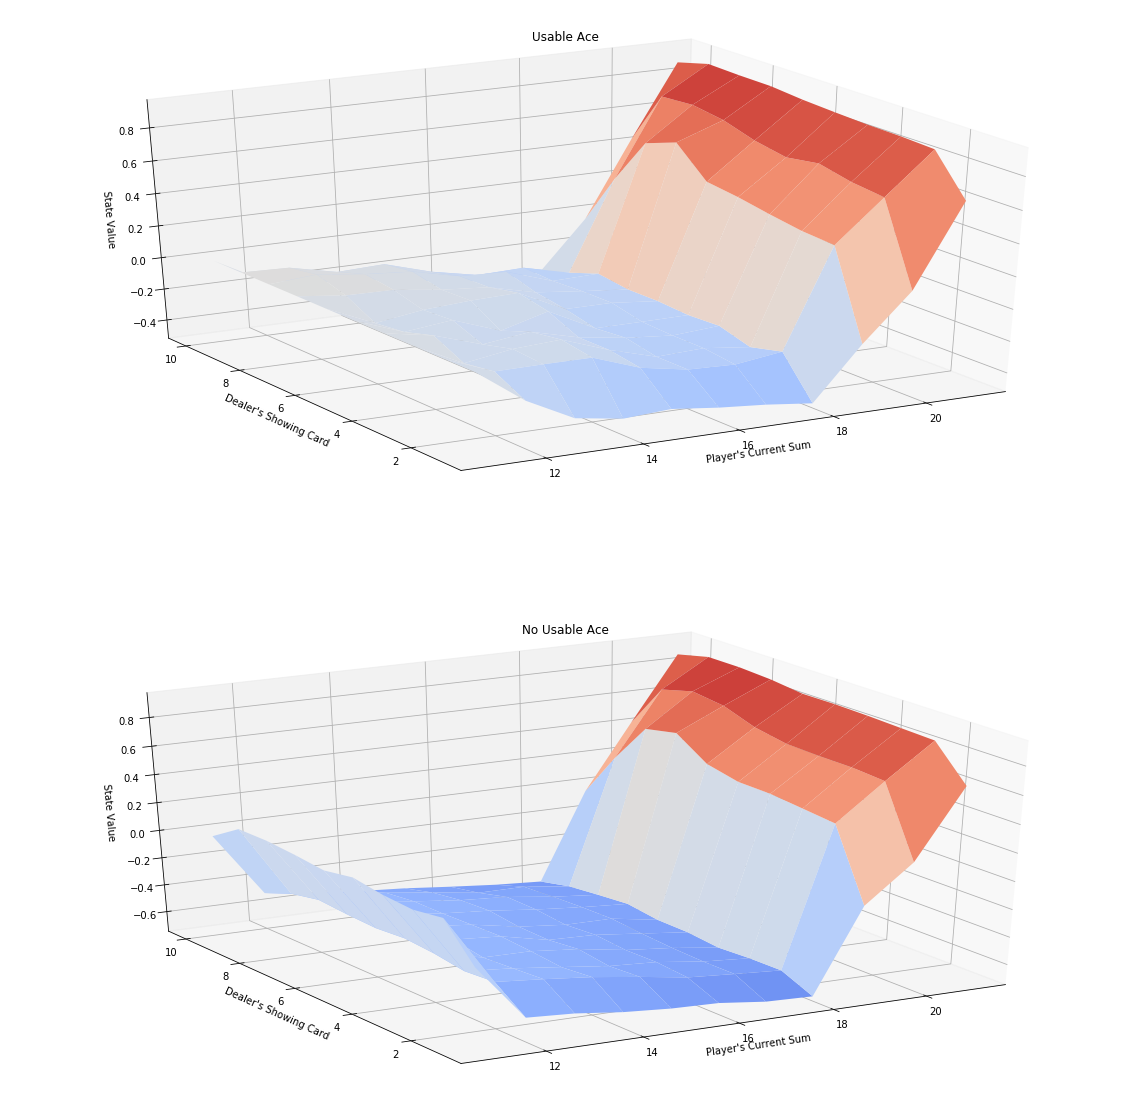

In [8]:
# Get the state-value function
V = mc_prediction_v(env, 500000, generate_episode_from_limit)

# plot the state-value function
plot_blackjack_values(V)

<br>

# 3. MC Prediction: Action Values

<hr>

In this section, you will write your own implementation of MC prediction (for estimating the action-value function).  

We will begin by investigating a policy where the player _almost_ always sticks if the sum of her cards exceeds 18.  In particular, she selects action `STICK` with 80% probability if the sum is greater than 18; and, if the sum is 18 or below, she selects action `HIT` with 80% probability.  The function `generate_episode_from_limit_stochastic` samples an episode using this policy. 

The pseudocode for (first-visit) MC prediction (for the action values) can be found below:

<img width="500px" src="images/first visit MC prediction action.png">

In [9]:
def generate_episode_from_limit_stochastic(bj_env):
    """
    Generating episode.
    
    ARGUMENTS
    ------------------
    - bj_env: This is an instance of OpenAI Gym's Blackjack environment.
    
    RETURNS
    ------------------
    - episode: This is a list of (state, action, reward) tuples (of tuples) and corresponds 
               to (𝑆0,𝐴0,𝑅1,…,𝑆𝑇−1,𝐴𝑇−1,𝑅𝑇) , where  𝑇  is the final time step. In particular, 
               episode[i] returns  (𝑆𝑖,𝐴𝑖,𝑅𝑖+1) , and episode[i][0], episode[i][1], and episode[i][2] 
               return  𝑆𝑖 ,  𝐴𝑖 , and  𝑅𝑖+1 , respectively.
    """
    # Initialize an empty array for episodes
    episode = []
    
    # Resets the state of the environment and returns an initial observation
    state = bj_env.reset()
    
    # Infinite loop
    while True:
        
        # Defining the probabilities:
        #     - The agent selects action STICK with 80% probability if the sum is greater than 18.
        #     - The agent selects action HIT with 80% probability if the sum is 18 or below.
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
        
        # Choose an action based on the give probabilities
        action = np.random.choice(np.arange(2), p=probs)
        
        # Run the one timestep of the environment's dynamics.
        next_state, reward, done, info = bj_env.step(action)
        
        # Append S,A,R to episode
        episode.append((state, action, reward))
        
        # Update the current state to the next state
        state = next_state
        
        # If done then break the loop
        if done:
            break
            
    return episode

Now, you are ready to write your own implementation of MC prediction.  Feel free to implement either first-visit or every-visit MC prediction; in the case of the Blackjack environment, the techniques are equivalent.

In [10]:
def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
    """
    First-Visit Monte Carlo (MC) Prediction algorithm.
    
    ARGUMENTS
    ----------------------
        - env: This is an instance of an OpenAI Gym environment.
        - num_episodes: This is the number of episodes that are generated through agent-environment 
                        interaction.
        - generate_episode: This is a function that returns an episode of interaction.
        - gamma: This is the discount rate. It must be a value between 0 and 1, inclusive 
                 (default value: 1).

    RETURNS
    ----------------------
        - Q: This is a dictionary (of one-dimensional arrays) where Q[s][a] is the estimated action 
             value corresponding to state s and action a.
    """
    
    # initialize an empty dictionary of arrays for the sum of the returns
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # initialize an empty dictionary of arrays for the number of visits
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # initialize an empty dictionary of arrays for the action-value function estimates
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Iterate through episodes
    for i_episode in range(1, num_episodes+1):
        
        # Print the episodes
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
            
        # Generate an episode
        episode = generate_episode(env)
        
        # Get the states, actions, and rewards
        states, actions, rewards = zip(*episode)
        
        # Prepare for discounting
        discounts = np.array([gamma**i for i in range(len(rewards)+1)])
        
        # Iterate through each state-action pair in the episode
        for i, state in enumerate(states):
            
            # Update the sum of the returns
            returns_sum[state][actions[i]] += sum(rewards[i:]*discounts[:-(1+i)])
            
            # Update the number of visits
            N[state][actions[i]] += 1.0
            
            # Update the action-value function estimates
            Q[state][actions[i]] = returns_sum[state][actions[i]] / N[state][actions[i]]
            
    return Q

Use the cell below to obtain the action-value function estimate $Q$.  We have also plotted the corresponding state-value function.

Episode 500000/500000.

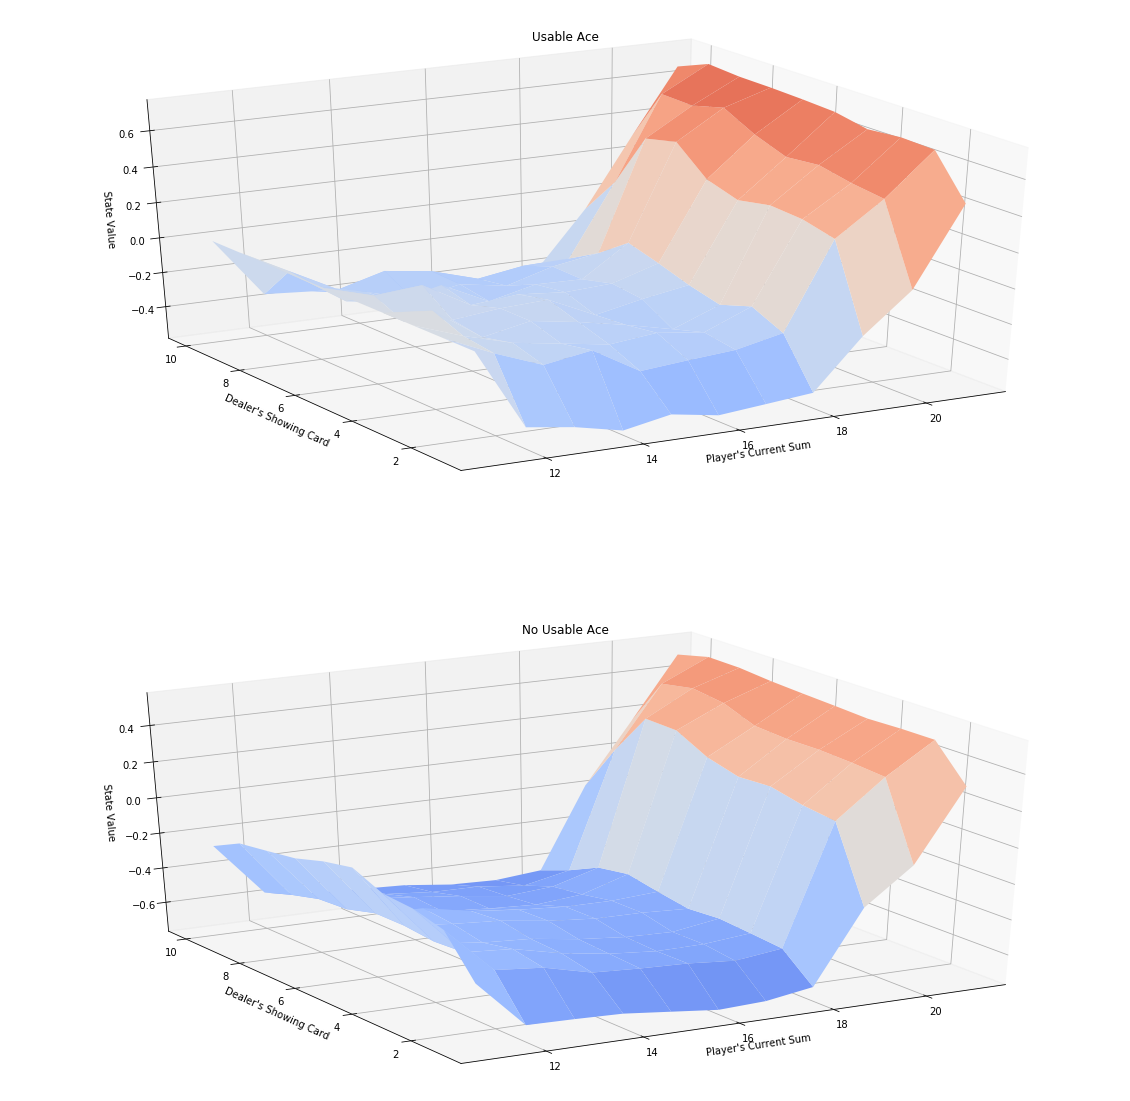

In [11]:
# Get the action-value function
Q = mc_prediction_q(env, 500000, generate_episode_from_limit_stochastic)

# Get the state-value function
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V_to_plot)

<br>

# 4. MC Control: GLIE

<hr>

In this section, you will write your own implementation of constant-$\alpha$ MC control.  

The pseudocode for (first-visit) GLIE MC control can be found below:

<img width="500px" src="images/glie.png/">

In [12]:
# Function for generating episode
def generate_episode_from_Q(env, Q, epsilon, nA):
    """ 
    Generates an episode from following the epsilon-greedy policy 
    
    ARGUMENTS
    ------------------
        - env: This is an instance of an OpenAI Gym environment.
        - Q: This is a dictionary (of one-dimensional arrays) where Q[s][a] is the estimated action 
             value corresponding to state s and action a.
        - epsilon
        - nA: Number of actions in action space
        
    RETURNS
    ------------------
        - episode
    """
    # Initialize an empty array for episodes
    episode = []
    
    # Resets the state of the environment and returns an initial observation
    state = env.reset()
    
    # Infinite loop
    while True:
        
        # Choose action
        action = np.random.choice(a = np.arange(nA), p = get_probs(Q_s = Q[state], epsilon = epsilon, nA = nA)) \
                                  if state in Q else env.action_space.sample()
        
        # Run one timestep of the environment's dynamics
        next_state, reward, done, info = env.step(action)
        
        # Append S, A, R to our array
        episode.append((state, action, reward))
        
        # Update the current state to next state
        state = next_state
        
        # If done then break the loop
        if done:
            break
            
    return episode

In [13]:
# Function for getting the probabilities for epsilon-greedy policy
def get_probs(Q_s, epsilon, nA):
    """ 
    Obtains the action probabilities corresponding to epsilon-greedy policy 
    
    ARGUMENTS
    ------------------
        - Q_s
        - epsilon
        - nA: Number of actions in action space
    
    RETURNS
    ------------------
        - policy_s
    """
    # Policy
    policy_s = np.ones(nA) * epsilon / nA
    
    # Best action
    best_a = np.argmax(Q_s)
    
    # Update policy
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    
    return policy_s

In [14]:
# Function for updating the action-value function using the most recent episode
def update_Q_GLIE(env, episode, Q, N, gamma):
    """ 
    Updates the action-value function estimate using the most recent episode 
    
    ARGUMENTS
    ------------------
        - env: This is an instance of an OpenAI Gym environment.
        - episode
        - Q: This is a dictionary (of one-dimensional arrays) where Q[s][a] is the estimated action 
             value corresponding to state s and action a.
        - N: Number of visits
        - gamma: This is the discount rate. It must be a value between 0 and 1, inclusive.
    
    RETURNS
    ------------------
        - Q: This is a dictionary (of one-dimensional arrays) where Q[s][a] is the estimated action 
             value corresponding to state s and action a.
        - N: Number of visits
    """
    # Retrieve thes S, A, R
    states, actions, rewards = zip(*episode)
    
    # Prepare for discounting
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    
    # Iterate through states
    for index, state in enumerate(states):
        
        # Get the action value
        old_Q = Q[state][actions[index]] 
        
        # Get the old number of visits
        old_N = N[state][actions[index]]
        
        # Update the action value
        Q[state][actions[index]] = old_Q + (sum(rewards[index:]*discounts[:-(index+1)]) - old_Q) / (old_N + 1)
        
        # Update the number of visits
        N[state][actions[index]] += 1
        
    return Q, N

In [15]:
# Function for Monte-Carlo (MC) Control with greedy in the limit with infinite exploration (GLIE)
def mc_control_GLIE(env, num_episodes, gamma=1.0):
    """
    Monte-Carlo (MC) Control with greedy in the limit with infinite exploration (GLIE).
    
        ARGUMENTS
    ----------------------
        - env: This is an instance of an OpenAI Gym environment.
        - num_episodes: This is the number of episodes that are generated through agent-environment 
                        interaction.
        - gamma: This is the discount rate. It must be a value between 0 and 1, inclusive (default 
                 value: 1).
    
    RETURNS
    ----------------------
        - Q: This is a dictionary (of one-dimensional arrays) where Q[s][a] is the estimated action 
             value corresponding to state s and action a.
        - policy: This is a dictionary where policy[s] returns the action that the agent chooses after 
                  observing state s.
    """
    # Number of actions in action space
    nA = env.action_space.n
    
    # Initialize the action-value function with zeros
    Q = defaultdict(lambda: np.zeros(nA))
    
    # Initializ ethe number of visits
    N = defaultdict(lambda: np.zeros(nA))
    
    # Iterate through episodes
    for i_episode in range(1, num_episodes+1):
        
        # Print the episode number
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
            
        # Set the value of epsilon
        epsilon = 1.0/((i_episode/8000)+1)
        
        # Generate an episode by following epsilon-greedy policy
        episode = generate_episode_from_Q(env, Q, epsilon, nA)
        
        # Update the action-value function estimate using the episode
        Q, N = update_Q_GLIE(env, episode, Q, N, gamma)
        
    # Determine the policy corresponding to the final action-value function estimate
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    
    return policy, Q

Use the cell below to obtain the estimated optimal policy and action-value function.

In [16]:
# Obtain the estimated optimal policy and action-value function
policy_glie, Q_glie = mc_control_GLIE(env, 500000)

Episode 500000/500000.

Next, we plot the corresponding state-value function.

In [17]:
# obtain the state-value function
V_glie = dict((k,np.max(v)) for k, v in Q_glie.items())

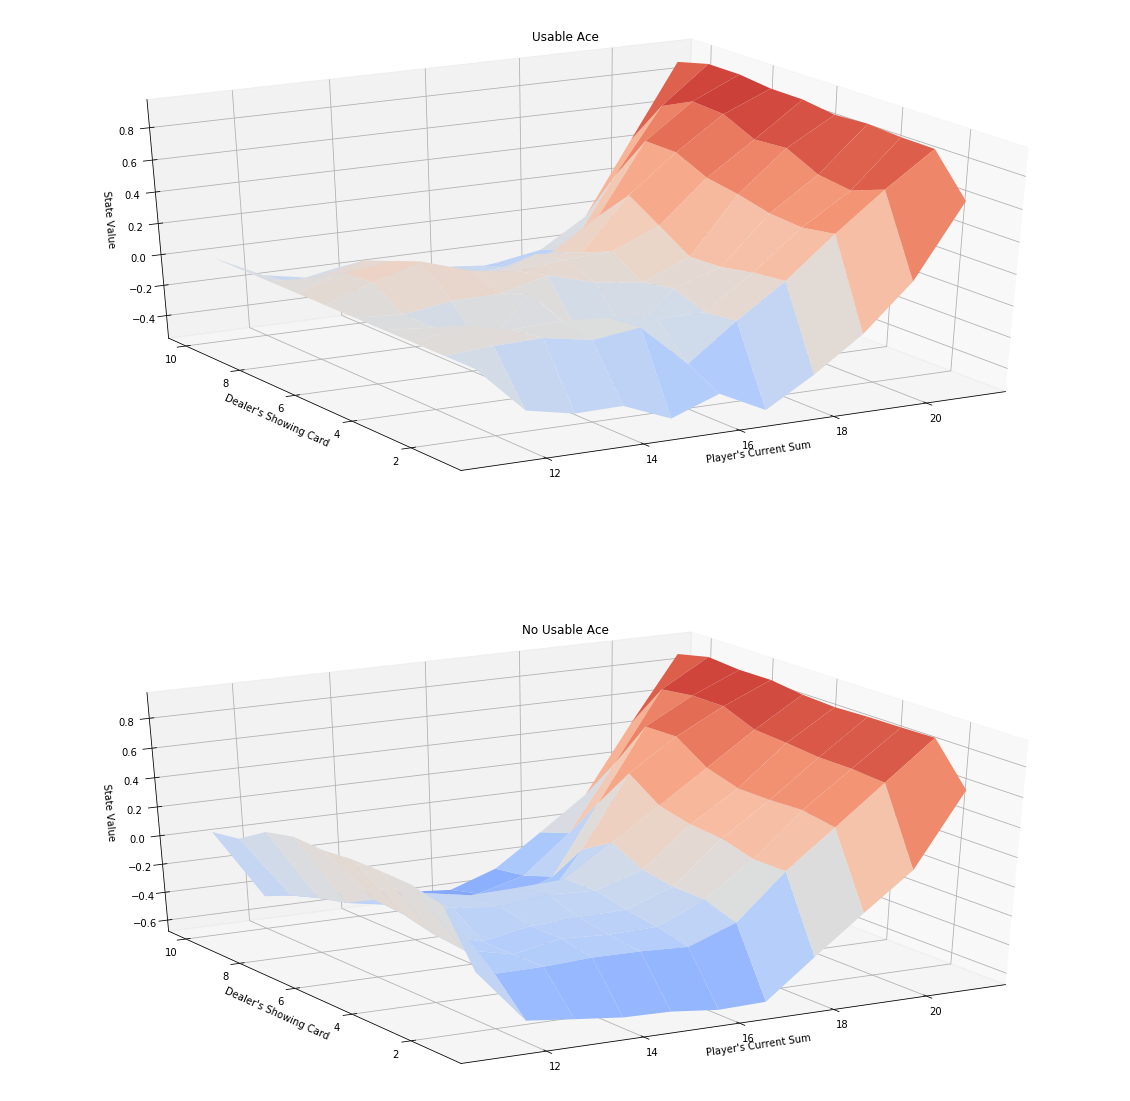

In [18]:
# plot the state-value function
plot_blackjack_values(V_glie)

Finally, we visualize the policy that is estimated to be optimal.

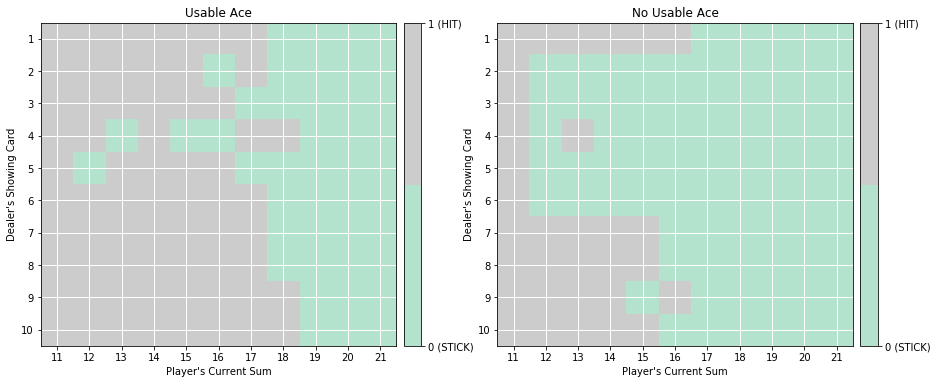

In [19]:
# Plot the policy
plot_policy(policy_glie)

The **true** optimal policy $\pi_*$ can be found on page 82 of the [textbook](http://go.udacity.com/rl-textbook) (and appears below).  Compare your final estimate to the optimal policy - how close are you able to get?  If you are not happy with the performance of your algorithm, take the time to tweak the decay rate of $\epsilon$ and/or run the algorithm for more episodes to attain better results.

![True Optimal Policy](images/optimal.png)

<br> 

# Part 4: MC Control: Constant-$\alpha$

<hr>

In this section, you will write your own implementation of constant-$\alpha$ MC control.  

The pseudocode for (first-visit) constant alpha MC control can be found below.

<img width="500px" src="images/mc-control-constant-a.png">

In [20]:
# Update the action-value function using the most recent episode
def update_Q_alpha(env, episode, Q, alpha, gamma):
    """ 
    Updates the action-value function estimate using the most recent episode 
    
    ARGUMENTS
    -------------------
        - env: This is an instance of an OpenAI Gym environment.
        - episode
        - Q:  This is a dictionary (of one-dimensional arrays) where Q[s][a] is the estimated action value 
              corresponding to state s and action a.
        - alpha: This is the step-size parameter for the update step.
        - gamma: This is the discount rate. It must be a value between 0 and 1, inclusive (default value: 1).
        
    RETURNS
    -------------------
        - Q:  This is a dictionary (of one-dimensional arrays) where Q[s][a] is the estimated action value 
              corresponding to state s and action a.

    """
    # Get the S, A, R
    states, actions, rewards = zip(*episode)
    
    # Prepare for discounting
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    
    # Iterate through states
    for i, state in enumerate(states):
        
        # Get the old action-value function
        old_Q = Q[state][actions[i]] 
        
        # Update the action-value function
        Q[state][actions[i]] = old_Q + alpha*(sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)
        
    return Q

In [21]:
# Function for MC Control Constant Alpha
def mc_control_alpha(env, num_episodes, alpha, gamma=1.0):
    """
    Implementation of MC Control Constant Alpha algorithm.
    
    ARGUMENTS
    --------------------
        - env: This is an instance of an OpenAI Gym environment.
        - num_episodes: This is the number of episodes that are generated through agent-environment interaction.
        - alpha: This is the step-size parameter for the update step.
        - gamma: This is the discount rate. It must be a value between 0 and 1, inclusive (default value: 1).
    
    RETURNS
    --------------------
        - Q: This is a dictionary (of one-dimensional arrays) where Q[s][a] is the estimated action value 
             corresponding to state s and action a.
        - policy: This is a dictionary where policy[s] returns the action that the agent chooses after 
                  observing state s.
    
    """
    # Get the number of actions in action space
    nA = env.action_space.n
    
    # Initialize the action-value function
    Q = defaultdict(lambda: np.zeros(nA))
    
    # Iterate through episodes
    for i_episode in range(1, num_episodes+1):
        
        # Print the episode number
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
            
        # Set the epsilon
        epsilon = 1.0/((i_episode/8000)+1)
        
        # Generate an episode by following epsilon-greedy policy
        episode = generate_episode_from_Q(env, Q, epsilon, nA)
        
        # Update the action-value function
        Q = update_Q_alpha(env, episode, Q, alpha, gamma)
        
    # Determine the policy corresponding to the final action-value function estimate
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    
    return policy, Q

Use the cell below to obtain the estimated optimal policy and action-value function.

In [22]:
# Get the estimated optimal policy and action-value function
policy_alpha, Q_alpha = mc_control_alpha(env, 500000, 0.02)

Episode 500000/500000.

Next, we plot the corresponding state-value function.

In [23]:
# Get the state-value function
V_alpha = dict((k,np.max(v)) for k, v in Q_alpha.items())

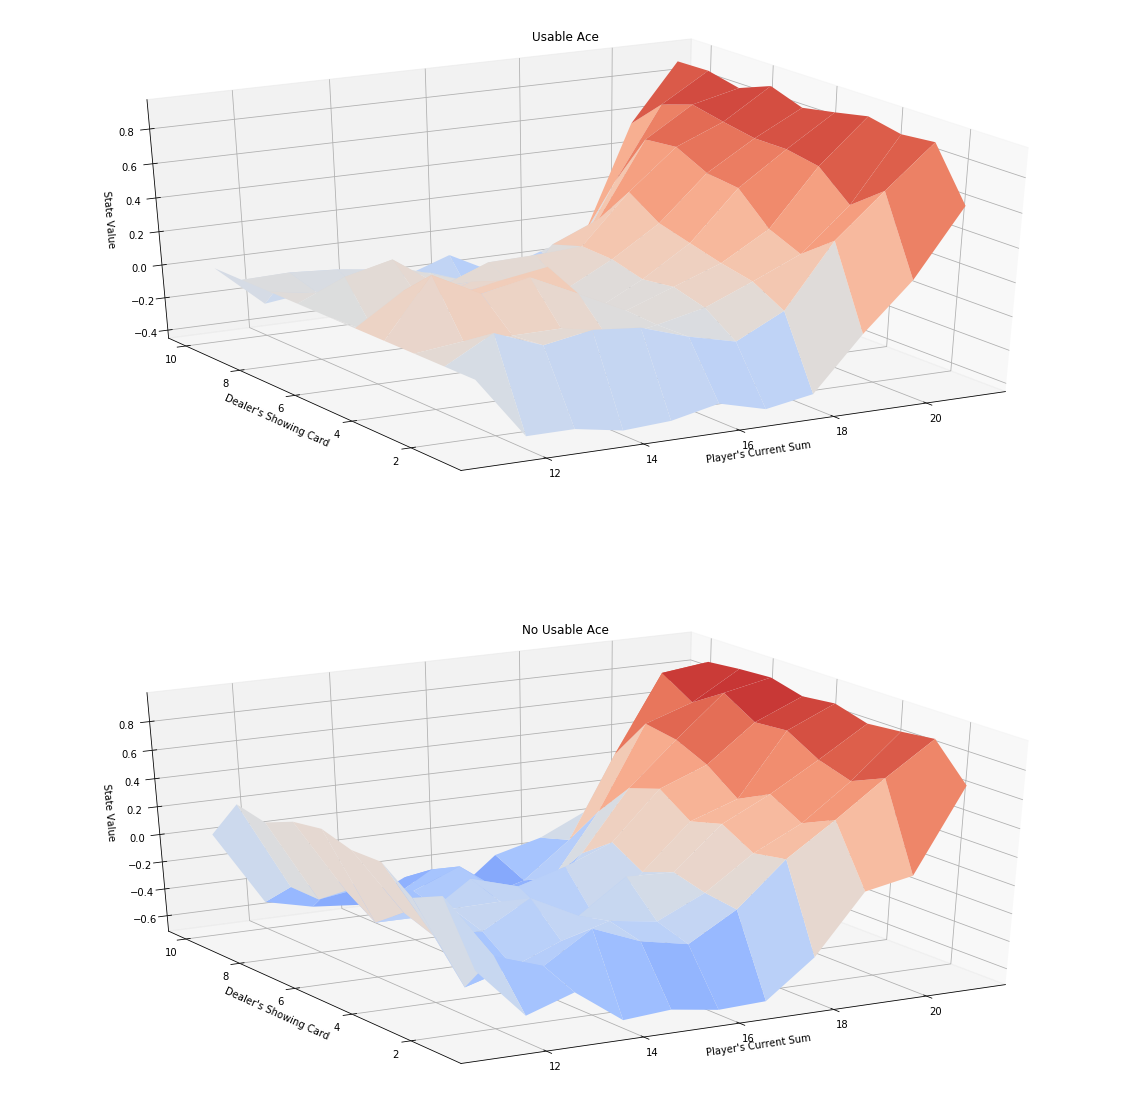

In [24]:
# plot the state-value function
plot_blackjack_values(V_alpha)

Finally, we visualize the policy that is estimated to be optimal.

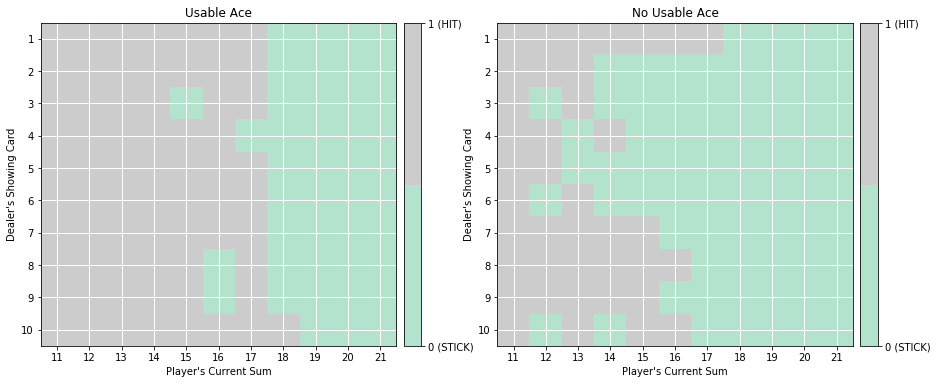

In [25]:
# Plot the policy
plot_policy(policy_alpha)

The **true** optimal policy $\pi_*$ can be found on page 82 of the [textbook](http://go.udacity.com/rl-textbook) (and appears below).  Compare your final estimate to the optimal policy - how close are you able to get?  If you are not happy with the performance of your algorithm, take the time to tweak the decay rate of $\epsilon$, change the value of $\alpha$, and/or run the algorithm for more episodes to attain better results.

![True Optimal Policy](images/optimal.png)